In [1]:
### All the packages we need:
%matplotlib inline
%load_ext rpy2.ipython

from Reader import Reader
from Randomforest import RandomForest_Autotunner,plot_matrix,Measure,check_rotate
from Traj_creator import Traj_data
from auxilary_function import MitoseClassif,final_classif_HMM


import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os.path
import cPickle as pkl

In [5]:
## names for the variables
y_name_3state="Type"         #variable name of the labels in the training set
classif_Mitose="MitoseOrNot" #variable name for the mitosis variable
classif_3state="3state"      #variable name for the classifier we wish to test
classif_final="Pred_fusion"  #variable name for the fusion of these two classifiers
classif_hmm="HMM"
num_str="0015" 
%Rpush classif_final classif_hmm

In [2]:
## Loading the normalized data

if os.path.isfile("H2b_data_norm_mult.csv"):
    print "The file existed so I loaded it."
    H2b_n_m = Traj_data(file_name="H2b_data_norm_mult.csv",pkl_traj_file="./Pkl_file") 

else:    
    H2b_n_m=Traj_data(pkl_traj_file="./Pkl_file") 

    H2b_n_m.extracting(num_str,"both_channels_0015.hdf5",'primary') 
    ## Extracting the hdf5 file for the primary channel (H2b)
    
    H2b_n_m.add_error() ## We had it so that the data won't have to do 0/0
    H2b_n_m.Add_traj(normalize=True)## ,num_traj=10) ## (you can reduce the number of traj)
    ## Adding Alice's work on tracking to have trajectories

    file_loc="0015_PCNA.xml"

    H2b_n_m.label_finder(file_loc) 
    ## Finding associated labels by minimizing distance by click and distance of cell

    H2b_n_m.renaming_and_merge() 
    ## renaming the labels to have G1=="1", S=="S", G2=="2" and M=="M" 
    #This procedure may take a long time.
    
    H2b_n_m.data.to_csv('H2b_data_norm_mult.csv',index=False,header=True) 

The file existed so I loaded it.
Traj_data built
Reader constructed
Updated member Group_of_traj


/home/pubuntu/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3006: DtypeWarning: Columns (245) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Updated member Group_of_traj
training dataset: 

S    217
1    199
2     56
M     36
Name: Type, dtype: int64
Processing time: 25.058245 in sec


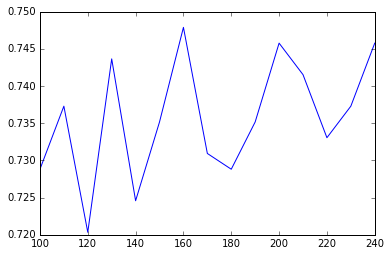

We now have a classifier with n=160, with an expected accuracy of 0.748 for the normalized data. 



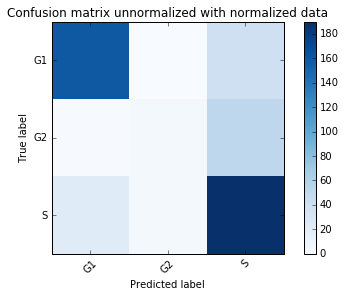

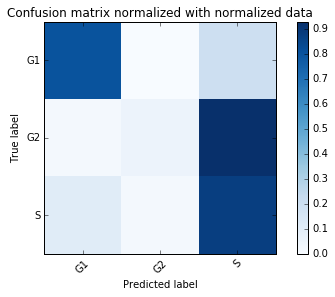

Frequency of predicted values for the 3 state classifier: 

1    15822
S    12540
2     1452
Name: 3state, dtype: int64


In [3]:
## classifier number 1

###
kfold=3

instances_to_keep=pd.notnull(H2b_n_m.data.traj)

H2b_n_m.data=H2b_n_m.data.ix[instances_to_keep,H2b_n_m.data.columns]

instances_to_change=H2b_n_m.data["Type"]!="M"

H2b_n_m.update()

print "training dataset: \n"
print H2b_n_m.train["Type"].value_counts()

if H2b_n_m.Var_missing[0] in H2b_n_m.train.columns:
    H2b_n_m.missing_features_train()
if H2b_n_m.Var_missing[0] in H2b_n_m.data.columns:
    H2b_n_m.missing_features_data()
values=[100 + i*10 for i in range(15)]
model_n_m=RandomForest_Autotunner(values)

model_n_m.tunning(H2b_n_m.train.ix[instances_to_change,H2b_n_m.names],H2b_n_m.train.ix[instances_to_change,"Type"],kfold,plot=True,fit_new_model=True)
plt.show()

i_=np.argmax(model_n_m.MSE)
n_tree=values[i_]
print "We now have a classifier with n=%d, with an expected accuracy of %5.3f for the normalized data. \n" %(n_tree,max(model_n_m.MSE))


plot_matrix(model_n_m.cm,title="Confusion matrix unnormalized with normalized data",names=["G1","G2","S"])
plt.show()
model_n_m.cm_normalized = model_n_m.cm.astype('float') / model_n_m.cm.sum(axis=1)[:, np.newaxis]
plot_matrix(model_n_m.cm_normalized,title="Confusion matrix normalized with normalized data",names=["G1","G2","S"])
plt.show() 

index_no_missing=H2b_n_m.data[H2b_n_m.names].dropna(axis=0, how='any').index
H2b_n_m.data.ix[index_no_missing,"3state"]=model_n_m.predict(H2b_n_m.data.ix[index_no_missing,H2b_n_m.names])
print "Frequency of predicted values for the 3 state classifier: \n"
print H2b_n_m.data.ix[index_no_missing,"3state"].value_counts()

We first load the unnormalized data: 

The file existed so I loaded it.
Traj_data built
Reader constructed
Updated member Group_of_traj
We train a classifier for mitosis or not: 

Reader constructed
Processing time: 251.406606 in sec


/home/pubuntu/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3066: DtypeWarning: Columns (245) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


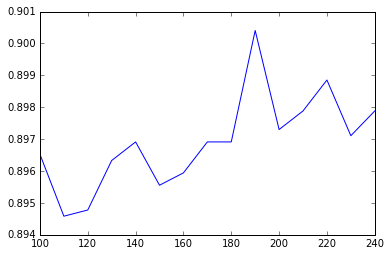

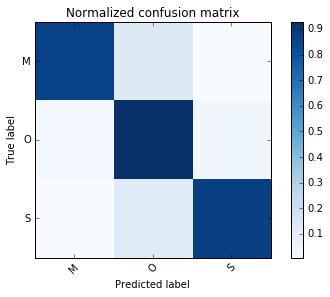

Updated member Group_of_traj
Updated member Group_of_traj
A bit of statistics on the overall predictions: 

Frequency of predicted values for the Mitosis or not classifier: 

S    14702
O    14222
M      890
Name: MitoseOrNot, dtype: int64

 We were however not able to predict 0 instances because of missing values
Updated member Group_of_traj
We prioritize our predictor of mitosis events before the 3 state classfier giving 
 us a four state classifier. 

Frequency of predicted values for the 4 state classifier: 

1    14933
S    12539
2     1452
M      890
Name: Pred_fusion, dtype: int64
Updated member Group_of_traj
We compute emission state probability matrix from the confusion matrix for the first classifier: 



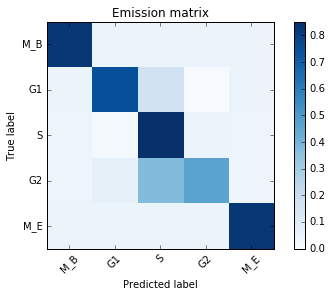

In [4]:

H2b_n_m,data,EmissionMat,model_1=MitoseClassif(H2b_n_m,model_n_m,
                                       y_name_3state=y_name_3state,
                                       classif_Mitose=classif_Mitose,
                                       classif_3state=classif_3state,
                                       classif_final=classif_final,
                                       num_str=num_str)

%Rpush data EmissionMat

In [6]:
%%R 
source("HMM_correcting_model.R")
list_obj=HMM_correct(data,EmissionMat,classif_final,obs_number=0)
data=list_obj$new_data
mean_t=list_obj$mean_t
var_t=list_obj$var_t
mean_e=list_obj$mean_e
var_e=list_obj$var_e
transProbs=list_obj$transProbs


[1] "We are here going to correct the data predicted in the first part \n \n         with a hidden markov where we infere the transition matrix with a \n\n         strong prior knowlegde in biology. A five state classifier : \n \n\n        M_E -> G1 -> S -> G2 -> M_E"
[1] "To assess briefly what is happening, we printed a sequence of observation, sequence number: 0"
  [1] 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [38] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 3 2 3 2 3 3 3 2 2
 [75] 2 2 3 3 3 3 3 2 3 3 2 3 2 2 3 2 2 3 3 3 3 2 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3
[112] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 4 3 3 3 3 3 4
[149] 3 3 3 3 3 3 3 4 4 3 3 4 3 3 3 3 3 3 4 3 3 4 3 3 3 3 3 4 3 4 4 2 5 5 5 5 5
Levels: 1 2 3 4 5
[1] "To assess briefly what is happening, we printed the corrected sequence, number: 0"
  [1] 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [38] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2

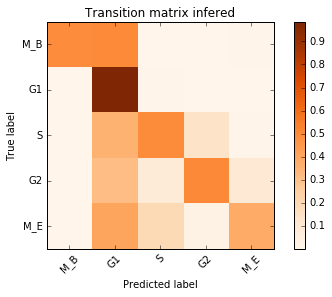

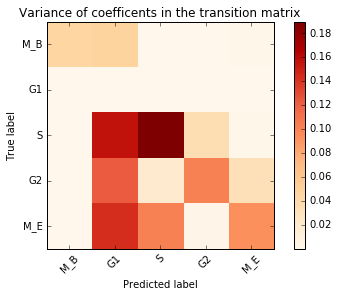

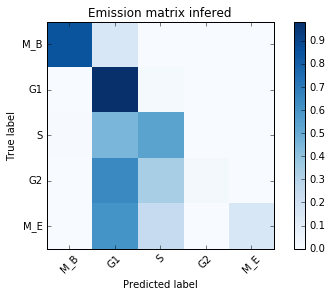

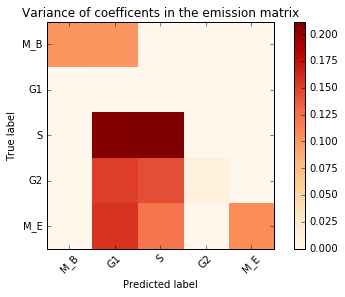

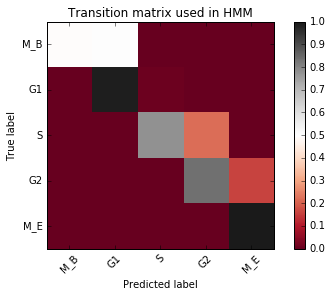

Here we are going to join the corrected data (from R) to our current data in Python 
 
Updated member Group_of_traj
Recap of our data: 
 
      traj Type MitoseOrNot 3state Pred_fusion HMM
694      0    1           O      1           1   1
1381     0    1           S      1           1   1
2460     0    1           S      1           1   1
5130     0    1           S      1           1   1
5958     0    1           S      1           1   1
We are going to count the lengths of the G1 phase, the S phase and the G2 phase: 

To quickly asses we print the trajectory and his corrected trajectory, for sequence number:0
Pred_fusion: 

['B' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' 'S' '1' '1' '1' '1' '1' '1' 'S' '1' 'S' '1' 'S' 'S' 'S'
 '1' '1' '1' '1' 'S' 'S' 'S' 'S' 'S' '1' 'S' 'S' '1' 'S' '1' '1' 'S' '1'


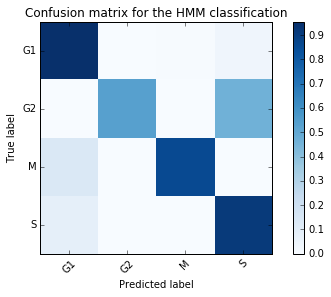

In [12]:
%Rpull mean_t mean_e var_t var_e transProbs data

plot_matrix(mean_t,title="Transition matrix infered",names=["M_B","G1","S","G2","M_E"],cmap=plt.cm.Oranges)
plt.show()
plot_matrix(var_t,title="Variance of coefficents in the transition matrix",names=["M_B","G1","S","G2","M_E"],cmap=plt.cm.OrRd)
plt.show()
plot_matrix(mean_e,title="Emission matrix infered",names=["M_B","G1","S","G2","M_E"])
plt.show()
plot_matrix(var_e,title="Variance of coefficents in the emission matrix",names=["M_B","G1","S","G2","M_E"],cmap=plt.cm.OrRd)
plt.show()
plot_matrix(transProbs,title="Transition matrix used in HMM",names=["M_B","G1","S","G2","M_E"],cmap=plt.cm.RdGy)
plt.show()

H2b_n_m,res=final_classif_HMM(data,H2b_n_m,
                  y_name_3state=y_name_3state,classif_Mitose=classif_Mitose,
                  classif_3state=classif_3state,classif_final=classif_final,classif_hmm=classif_hmm,
                             ratio=5.9/60)

In [13]:
pd.DataFrame(res)

,Accepted trajectories,Standard deviation,mean
G1,164,4.006669,7.455945
S,116,3.308392,7.547083
G2,116,2.228969,1.804756
CellCycle,116,2.590818,17.161710


In [15]:
%%R
transProbs

         [,1]      [,2]       [,3]      [,4]      [,5]
[1,] 0.493855 0.5061450 0.00000000 0.0000000 0.0000000
[2,] 0.000000 0.9890347 0.01096527 0.0000000 0.0000000
[3,] 0.000000 0.0000000 0.77892193 0.2210781 0.0000000
[4,] 0.000000 0.0000000 0.00000000 0.8391819 0.1608181
[5,] 0.000000 0.0000000 0.00000000 0.0000000 1.0000000
